In [1]:
import os, sys, csv

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import cv2 as cv

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [4]:
torch.cuda.is_available()
device = 'cuda:0'

In [5]:
# BoostNet Dataset
# from SpineWeb dataset16
# link: http://spineweb.digitalimaginggroup.ca/spineweb/index.php?n=Main.Datasets

class BoostNetDataset(torch.utils.data.Dataset):
    def __init__(self, path, train=True):
        self.images = []
        self.labels = []
        
        if train:
            image_path = path + "/data/training/"
            names = csv.reader(open(path + "/labels/training/filenames.csv", 'r'))
            landmarks = csv.reader(open(path + "/labels/training/landmarks.csv", 'r'))
        else:
            image_path = path + "/data/test/"
            names = csv.reader(open(path + "/labels/test/filenames.csv", 'r'))
            landmarks = csv.reader(open(path + "/labels/test/landmarks.csv", 'r'))
        
        for landmark_each_image in landmarks:
            coordinate_list = []
            for coordinate in landmark_each_image:
                coordinate_list.append(float(coordinate))
            self.labels.append(torch.Tensor(coordinate_list))

        for i, name in enumerate(names):
            origin_image = cv.imread(image_path + name[0], cv.IMREAD_GRAYSCALE)
            
            target_height = 512
            target_width = 256
            image = np.zeros((target_height, target_width), np.uint8)
            cv.resize(origin_image, (target_width, target_height), image)
            
            image = np.reshape(image, (1, image.shape[0], image.shape[1]))
            image_tensor = torch.from_numpy(image).float()
            
            self.images.append(image_tensor)

        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        
        return image, label
    
    def __len__(self):
        return len(self.images)

In [6]:
# define network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3, 1, 1)
        self.conv2 = nn.Conv2d(4, 8, 3, 1, 1)
        self.conv3 = nn.Conv2d(8, 16, 3, 1, 1)
        self.conv4 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv5 = nn.Conv2d(32, 32, 3, 1, 1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(32 * 16 * 8, 512)
        self.fc2 = nn.Linear(512, 136)
        
    def forward(self, x):        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        
        x = x.view(-1, 32 * 16 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
net = ConvNet()
net = net.to(device)

In [8]:
# define loss function
import torch.optim as optim

criterion = nn.MSELoss().to(device)

optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)

In [9]:
# function to compute loss

def compute_loss(net, data_loader):
    loss_sum = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs.float(), labels.float()) 
            loss_sum += loss.item()
            
    return loss_sum / len(data_loader)

In [14]:
path = "E:/Workspace/AASCE2019/boostnet_labeldata"
train_data = BoostNetDataset(path, train=True)
test_data = BoostNetDataset(path, train=False)

batch = 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch,
                                         shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch,
                                         shuffle=True, num_workers=0)


print("number of batches(training): ", len(train_loader))
print("number of batches(testing): ", len(test_loader))

number of batches(training):  121
number of batches(testing):  32


In [15]:
epoch_num = 10

loss1 = []
loss2 = []

for epoch in range(epoch_num):
   
    for data in train_loader:

        # get the inputs
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()
        
    scheduler.step()    
    
    train_loss = compute_loss(net, train_loader)
    loss1.append(train_loss)

    test_loss = compute_loss(net, test_loader)
    loss2.append(test_loss)
    print("epoch number", epoch+1, "train_loss", train_loss, "test_loss", test_loss)

print('Finished Training')

epoch number 1 train_loss 0.012998216733536568 test_loss 0.01291149370081257
epoch number 2 train_loss 0.0076420305773985285 test_loss 0.007806492860254366
epoch number 3 train_loss 0.00813361493993766 test_loss 0.006796298610424856
epoch number 4 train_loss 0.0040809470873464605 test_loss 0.004574731214233907
epoch number 5 train_loss 0.00329455931349619 test_loss 0.0035663400049088523
epoch number 6 train_loss 0.0026499254572251428 test_loss 0.0039629300372325815
epoch number 7 train_loss 0.0022340072819208804 test_loss 0.0031340012974396814
epoch number 8 train_loss 0.0018409398015904095 test_loss 0.0031475408759433776
epoch number 9 train_loss 0.001675556978106899 test_loss 0.003186992533301236
epoch number 10 train_loss 0.0017073863096465935 test_loss 0.003384666910278611
Finished Training


In [16]:
# save trained model
torch.save(net, 'E:/Workspace/AASCE2019/ConvNet.pth')

C:\Users\wlgq\AppData\Local\conda\conda\envs\pt\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [17]:
def CVimshow2pltimshow(cv_img):
    """
    cv_img: [3, height, width], BGR, numpy array, int(0-255)
    """
    b,g,r = cv.split(cv_img)  
    plt_img = cv.merge([r,g,b]).astype(np.int)
    return plt_img

In [21]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 20)

In [23]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
batch, channel, height, width = images.shape

ret = net(images.to(device))

batch_img = np.zeros((height, width * batch, 3), np.int)

for i in range(batch):
    sample = images[i].numpy().squeeze(0)
    sample_BGR = cv.cvtColor(sample, cv.COLOR_GRAY2BGR)

    label = labels[i]
    predict = ret[i]

    point_num = len(label) // 2
    for j in range(point_num):
        cv.circle(sample_BGR, (int(label[j] * width), int(label[j + point_num]* height)), 2, (255, 255, 0))
        cv.circle(sample_BGR, (int(predict[j] * width), int(predict[j + point_num]* height)), 2, (0, 0, 255))
        
    plt_img = CVimshow2pltimshow(sample_BGR)
    batch_img[:, i * width:(i+1) * width, :] = plt_img

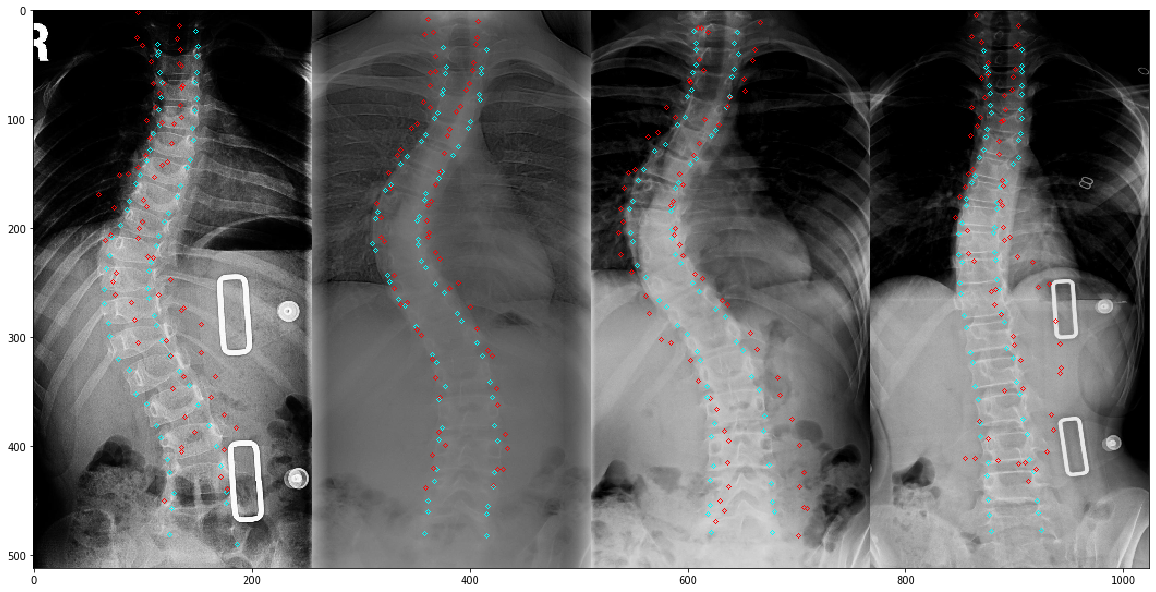

In [24]:
plt.imshow(batch_img)